In [4]:
! pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.7.0/MindSpore/cpu/x86_64/mindspore-1.7.0-cp37-cp37m-macosx_10_15_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple
! pip install easydict
! pip install feature-engine

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 MB 1.0 MB/s eta 0:00:00m eta 0:00:010:00:04


In [ ]:
! pip install -U scikit-multiflow

In [1]:
import pandas as pd 
import numpy as np 
import itertools
import mindarmour
import matplotlib
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('../data/ml_100k/train_data.csv')
train_df.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [3]:
item_df = pd.read_csv('../data/ml_100k/item_data.csv')
item_df.head()

,id,title,release_date,video_release_date,url,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
item_edf = item_df.drop(columns=['title', 'release_date', 'video_release_date', 'url', 'unknown'])
item_edf.head(3)

,id,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [5]:
user_df = pd.read_csv('../data/ml_100k/user_data.csv')
user_df.head()

,id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [6]:
from feature_engine.encoding import OrdinalEncoder

encoder = OrdinalEncoder(encoding_method='arbitrary', variables=['gender', 'occupation'])
user_edf = encoder.fit_transform(user_df)
user_edf.head()

,id,age,gender,occupation,zip_code
0,1,24,0,0,85711
1,2,53,1,1,94043
2,3,23,0,2,32067
3,4,24,0,0,43537
4,5,33,1,1,15213


---
Item-based concept drift analysis

In [11]:
# select time series data patch from the dataset
item_id = 1
idf = train_df.loc[train_df['item_id']==item_id, :]
idf.sort_values(by='timestamp', inplace=True)
merged_df = pd.merge(left=idf, right=user_edf.iloc[:, :4], how='left', left_on='user_id', right_on='id')
merged_df.drop(columns=['item_id', 'timestamp', 'id'], inplace=True)
data = merged_df.values 
data

/Users/nipunpathitage/opt/anaconda3/envs/rec/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([[276,   5,  21,   0,   5],
       [821,   5,  37,   0,  14],
       [817,   4,  19,   0,   5],
       ...,
       [411,   4,  34,   0,   7],
       [532,   5,  20,   0,   5],
       [416,   5,  20,   1,   5]])

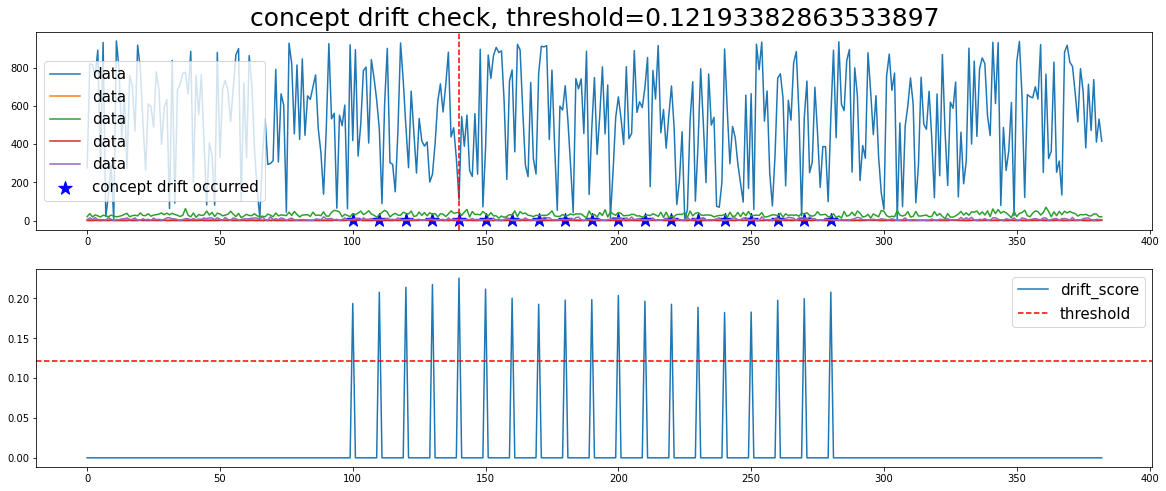

In [13]:
from mindarmour import ConceptDriftCheckTimeSeries

concept = ConceptDriftCheckTimeSeries(window_size=100, rolling_window=10, step=10, threshold_index=1.5,need_label=False)
drift_score, threshold, concept_drift_location = concept.concept_check(data)

---
User-based concept drift analysis

In [17]:
# select time series data patch from the dataset
user_id = 1
udf = train_df.loc[train_df['user_id']==user_id, :]
udf.sort_values(by='timestamp', inplace=True)
merged_df = pd.merge(left=udf, right=item_edf, how='left', left_on='user_id', right_on='id')
merged_df.drop(columns=['user_id', 'timestamp', 'id'], inplace=True)
data = merged_df.values 
data



/Users/nipunpathitage/opt/anaconda3/envs/rec/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([[172,   5,   0, ...,   0,   0,   0],
       [168,   5,   0, ...,   0,   0,   0],
       [165,   5,   0, ...,   0,   0,   0],
       ...,
       [111,   5,   0, ...,   0,   0,   0],
       [  5,   3,   0, ...,   0,   0,   0],
       [256,   4,   0, ...,   0,   0,   0]])

/Users/nipunpathitage/opt/anaconda3/envs/rec/lib/python3.7/site-packages/mindarmour/reliability/concept_drift/concept_drift_check_time_series.py:144: RuntimeWarning: invalid value encountered in true_divide
  data_av = (data_av - data_av.min()) / (data_av.max() - data_av.min())


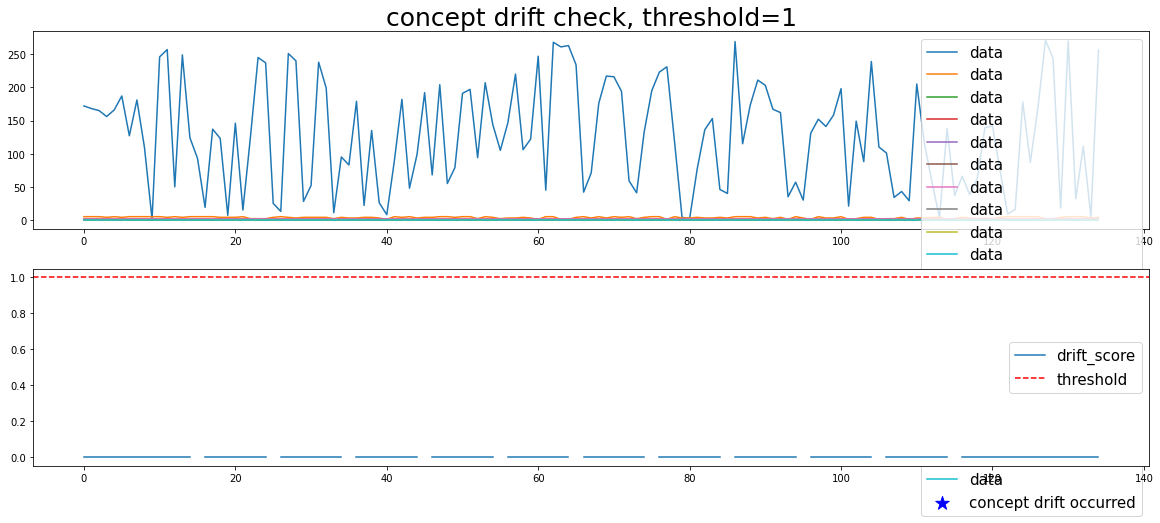

In [19]:
from mindarmour import ConceptDriftCheckTimeSeries

concept = ConceptDriftCheckTimeSeries(window_size=15, rolling_window=10, step=10, threshold_index=1.5,need_label=False)
drift_score, threshold, concept_drift_location = concept.concept_check(data)

---
Custom metrics for evaluate data drift

In [ ]:
# Adaptive windowing algorithm

# select time series data patch from the dataset
item_id = 1
idf = train_df.loc[train_df['item_id']==item_id, :]
idf.sort_values(by='timestamp', inplace=True)
merged_df = pd.merge(left=idf, right=user_edf.iloc[:, :4], how='left', left_on='user_id', right_on='id')
merged_df.drop(columns=['item_id', 'timestamp', 'id'], inplace=True)
data = merged_df.values 

from skmultiflow.drift_detection import ADWIN

adwin = ADWIN()
# reports 
dc, dwz, gc = [], [], []
for r in data:
    adwin.add_element(r)
    dc.append(adwin.detected_change())
    dwz.append(adwin.detected_warning_zone())
    gc.append(adwin.get_change())
